In [64]:
import os
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import cv2

# Augument data

In [65]:
from skimage import transform
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform

def augument(img, out_path):
  img = cv2.resize(img, (32,96))
  cv2.imwrite(out_path + f'0.jpg', img)
  cnt = 1
  for rot in (np.random.rand(1,3) * 10 - 5):
    for brightness in (np.random.rand(5)-0.5)*0.1:
      for contrast in (np.random.rand(1)*0.5+1):
        scale = (np.random.rand(1)- 0.5)*0.5+1
        shear = (np.random.rand(1)- 0.5)*0.5
        tf = AffineTransform(scale=scale[0], shear=shear[0])
        img_aug = transform.warp(img, tf, order=1, preserve_range=True, mode='edge')
        img_aug = rotate(img, angle=rot[0], mode='edge')
        img_aug *= contrast
        img_aug += brightness
        if np.random.rand(1) > 0.5:
          img_aug = np.fliplr(img_aug)
        img_aug = random_noise(img_aug, var=(np.random.rand(1)/15)**2)
        cv2.imwrite(out_path + f'{cnt}.jpg', img_aug * 255)
        cnt += 1

In [66]:
aug_path = 'aug_dataset'
if not os.path.exists(aug_path):
    os.mkdir(aug_path)

classes = os.listdir('dataset')

for cls in classes:
  cls_folder = os.path.join(aug_path, cls)
  if not os.path.exists(cls_folder):
    os.mkdir(cls_folder)
  
  src_cls_path = os.path.join('dataset', cls)
  for i, file in enumerate(os.listdir(src_cls_path)):
    img = cv2.imread(os.path.join(src_cls_path, file))
    augument(img, f'./aug_dataset/{cls}/{i}')
  

# Test HOG function

(2576,)


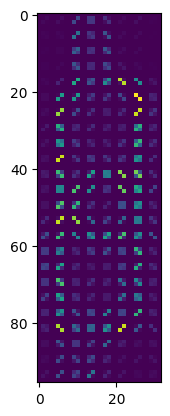

In [67]:
from skimage.feature import hog

img = cv2.imread('aug_dataset/yellow/01.jpg')

fd, hog_image = hog(img, orientations=4, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

plt.imshow(hog_image)
print(fd.shape)

# Map data

In [68]:
x = []
y = []
mapping = {}
for i, cls in enumerate(os.listdir('aug_dataset')):
  path_to_cls = os.path.join('aug_dataset', cls)
  files = [os.path.join(path_to_cls, f) for f in os.listdir(path_to_cls)]
  x += files
  y += [i] * len(files)
  mapping[i] = cls

In [69]:
import pickle

model_path = './model'
if not os.path.exists(model_path):
    os.mkdir(model_path)

with open(os.path.join(model_path, 'mapping.p'), 'wb') as handle:
    pickle.dump(mapping, handle)
    
print(mapping)

{0: 'yellow', 1: 'green', 2: 'red', 3: 'background'}


# Train SVM

In [70]:
hog_features = []
y_good = []
for i, img_path in enumerate(x):
  img = cv2.imread(img_path)
  fd = hog(img, orientations=4, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
  hog_features.append(fd)
  y_good.append(y[i])

In [71]:
features = {'y': y_good, 'hog': hog_features}
with open(os.path.join(model_path, 'hog_features.p'), 'wb') as handle:
    pickle.dump(features, handle)

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(hog_features), np.array(y_good), test_size=0.1, random_state=42)

print(f'Numer of trining examples: {len(X_train)}')
print(f'Numer of trining test: {len(X_test)}')

Numer of trining examples: 12198
Numer of trining test: 1356


In [73]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [74]:
from sklearn.metrics import classification_report,accuracy_score

y_pred = clf.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9977876106194691


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       180
           1       1.00      1.00      1.00       166
           2       1.00      0.99      0.99       180
           3       1.00      1.00      1.00       830

    accuracy                           1.00      1356
   macro avg       1.00      1.00      1.00      1356
weighted avg       1.00      1.00      1.00      1356



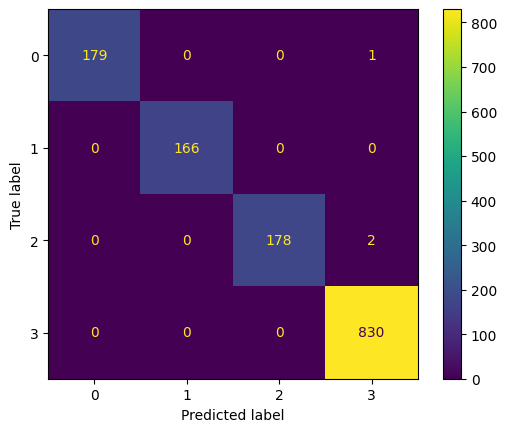

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [76]:
with open(os.path.join(model_path, 'svm.p'), 'wb') as handle:
    pickle.dump(clf, handle)